# Imports

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv("dataset/phase_3_TRAIN_7d499bff69ca69b6_6372c3e_MLPC2021_generic.csv")
# df.head()

# Split dataset into inputs and targets

In [4]:
# drop target value, student annotations and string ID from input features:
X = df.drop(columns=['quadrant','mean_A','mean_V','id','score_mode','score_key_strength'])

# we want to predict the quadrant:
y = df['quadrant'].values

In [5]:
X.head()

,essentia_dissonance_mean,essentia_dissonance_stdev,essentia_dynamic_complexity,essentia_loudness,essentia_onset_rate,essentia_pitch_salience_mean,essentia_pitch_salience_stdev,essentia_spectral_centroid_mean,essentia_spectral_centroid_stdev,essentia_spectral_complexity_mean,...,librosa_spectral_bandwidth_stdev,librosa_spectral_flatness_mean,librosa_spectral_flatness_stdev,midlevel_features_melody,midlevel_features_articulation,midlevel_features_rhythm_complexity,midlevel_features_rhythm_stability,midlevel_features_dissonance,midlevel_features_tonal_stability,midlevel_features_minorness
0,0.206445,0.131383,13.998791,58.329521,3.1,0.539736,0.193987,3367.790527,3684.124268,2.986095,...,1781.705789,0.139911,0.248388,0.065397,-0.029380,-0.303987,-0.053306,-0.325228,0.347745,-0.119278
1,0.145753,0.057971,3.533264,75.166183,4.2,0.476832,0.123564,1395.528809,401.987610,4.181923,...,721.292781,0.000275,0.000484,0.353040,-0.073957,-0.381182,0.120750,-0.479266,0.451572,-0.064252
2,0.149111,0.059011,3.337368,82.753929,4.3,0.457741,0.132359,1318.759644,289.306152,4.303592,...,583.569947,0.000202,0.000314,0.201885,0.016944,-0.337422,0.103853,-0.388214,0.430684,-0.226197
3,0.163914,0.057474,3.078172,79.024742,4.1,0.504427,0.121134,1258.258423,262.561310,5.271147,...,575.961419,0.000202,0.000257,0.181998,-0.019165,-0.314282,0.118872,-0.335902,0.314371,-0.006619
4,0.157382,0.054116,2.682208,59.633064,3.9,0.503377,0.121658,1244.375122,260.756195,4.122828,...,539.887336,0.000217,0.000241,0.256362,-0.151648,-0.302913,-0.002940,-0.395495,0.368037,-0.162711


In [6]:
#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Simple Decision Tree (no normalization)

In [14]:
# Create DecisionTreeClassifier
clf = tree.DecisionTreeClassifier()

# Fit the classifier to the data
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.6149425287356322

## As opposed to kNN, normalizing data decreases Decision Tree performance

In [15]:
X_normalized = MinMaxScaler().fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=1, stratify=y)

In [16]:
clf = tree.DecisionTreeClassifier()

# Fit the classifier to the normalized data
clf.fit(X_train,y_train)

clf.score(X_test, y_test)

0.632183908045977

# Decision Tree with Cross-Validation

In [9]:
param_grid = {'criterion':['gini','entropy'],
              'splitter': ['best', 'random'],
              'max_depth':[1,2,3,4,6,8,10,12,15,30, 60, 100, 1000]#,
              #'min_samples_split': list(range(2, 10, 2))
             }

gscv = GridSearchCV(clf, param_grid, cv=5, return_train_score=True)

gscv.fit(X, y)

scores_all_features = gscv.cv_results_["mean_test_score"]

print("### all 87 features, no normalization ###")
print("best params: ", gscv.best_params_, "\nbest score: ",gscv.best_score_, "\n")


### all 89 features, no normalization ###
best params:  {'criterion': 'entropy', 'max_depth': 4, 'splitter': 'random'} 
best score:  0.6444363550790184 



In [12]:
gscv_normalized = GridSearchCV(clf, param_grid, cv=5, return_train_score=True)

gscv_normalized.fit(X_normalized, y)

scores_all_features_normalized = gscv_normalized.cv_results_["mean_test_score"]

print("### all 87 features, normalized to [0, 1] ###")
print("best params:", gscv_normalized.best_params_, "\nbest score: ", gscv_normalized.best_score_,  "\n")

### all 87 features, normalized to [0, 1] ###
best params: {'criterion': 'gini', 'max_depth': 2, 'splitter': 'random'} 
best score:  0.6448217030320412 



# Evaluation

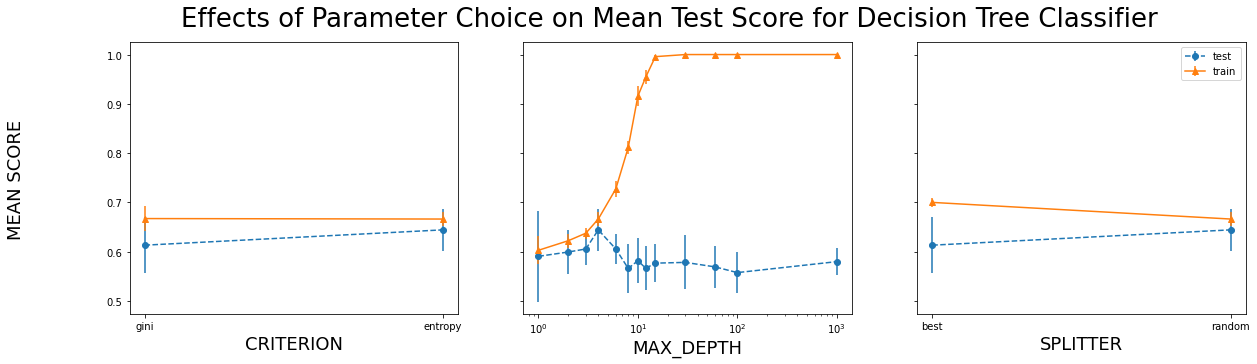

In [11]:
def plot_search_results(grid, title="Score per parameter", log_list=[]):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle(title, fontsize=26)
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical', fontsize=18)
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper(), fontsize=18)
        if p in log_list: 
            ax[i].set_xscale('log')


    plt.legend()
    plt.show()

plot_search_results(gscv, title="Effects of Parameter Choice on Mean Test Score for Decision Tree Classifier", log_list=["max_depth"])

#plot_search_results(gscv_normalized, title="Effects of Parameter Choice on Mean Test Score for Decision Tree Classifier (normalized data)", log_list=["max_depth"])